<a href="https://colab.research.google.com/github/JorgeZarama/TFM-final-models/blob/main/Analisis_de_Sentimiento_Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar Clases

In [ ]:
import numpy as np
import pandas as pd
import string
import re
import unidecode
import codecs
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

## Concatemaos todos los conjuntos de datos

In [ ]:
# Se estrajo del conjunto de datos

ruta_archivo_1 = "filtered_googl_records1.csv"
ruta_archivo_2 = "filtered_GOOGL_records2.csv"
ruta_archivo_3 = "filtered_asml_records1.csv"
ruta_archivo_4 = "filtered_ASML_records2.csv"
ruta_archivo_5 = "filtered_LRCX_records1.csv"
ruta_archivo_6 = "filtered_LRCX_records2.csv"
ruta_archivo_7 = "filtered_NVDA_records.csv"
ruta_archivo_8 = "filtered_NVDA_records2.csv"
ruta_archivo_9 = "filtered_tms_records1.csv"
ruta_archivo_10 = "filtered_TMS_records2.csv"

In [ ]:

df1 = pd.read_csv(ruta_archivo_1)
df2 = pd.read_csv(ruta_archivo_2)
df3 = pd.read_csv(ruta_archivo_3)
df4 = pd.read_csv(ruta_archivo_4)
df5 = pd.read_csv(ruta_archivo_5)
df6 = pd.read_csv(ruta_archivo_6)
df7 = pd.read_csv(ruta_archivo_7)
df8 = pd.read_csv(ruta_archivo_8)
df9 = pd.read_csv(ruta_archivo_9)
df10 = pd.read_csv(ruta_archivo_10)

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], axis=0)

# Visualizar las primeras filas del DataFrame
display(df.head(10))
display(df.tail(10))
display(df['sent_merged'].unique())
df.describe(include='all')
df.info()


,ticker,id_msg,msg,date,sent,id_user,foll,ideas,clean_text,sent_new,sent_merged,sent_new_noros,bullish_proba
0,GOOGL,21652759,reminder that google class a shares will start...,2014-04-02 12:52:59+00:00,0,112427,96,2002,reminder that google class share will start tr...,1,1,1,0.856359
1,GOOGL,21663214,the difference between $goog and $googl will s...,2014-04-02 15:17:47+00:00,0,285820,560,13587,the difference between and will show the value...,-1,1,1,0.740180
2,GOOGL,21669778,.@strattonite america is a country of non-vote...,2014-04-02 16:52:40+00:00,0,6979,53955,27859,america be country of non voter dont think itl...,-1,0,0,0.690672
3,GOOGL,21680894,@marketswingplayer i believe its&#39; $googl,2014-04-02 19:56:58+00:00,0,241057,10,117,believe its,1,1,1,0.917867
4,GOOGL,21682596,double the google? double the fun? will be int...,2014-04-02 20:21:54+00:00,0,23887,226402,39580,double the google double the fun will be inter...,1,1,1,0.886418
5,GOOGL,21692879,tomorrow we&#39;ll get to see if no vote $goog...,2014-04-03 02:39:29+00:00,0,291928,62,8460,tomorrow well get to see if no vote get discou...,1,1,1,0.948774
6,GOOGL,21694850,early german trading. $goog indicated slightly...,2014-04-03 06:41:14+00:00,0,212,50,71,early german trading indicate slightly low hig...,1,1,1,0.889112
7,GOOGL,21695169,$googl somebody sold/bought at around 1000-110...,2014-04-03 08:11:06+00:00,0,82876,44,1807,somebody sell buy at around this morning lol p...,-1,0,0,0.682647
8,GOOGL,21695352,component $googl will commence during regular ...,2014-04-03 08:48:06+00:00,1,118770,8,365,component will commence during regular trading...,0,1,1,0.777955
9,GOOGL,21695684,$googl and $goog wish i had some of the non-tr...,2014-04-03 09:58:35+00:00,1,278526,7,35,and wish have some of the non trade share,1,1,1,0.941193


,ticker,id_msg,msg,date,sent,id_user,foll,ideas,clean_text,sent_new,sent_merged,sent_new_noros,bullish_proba
81,TMS,58444987,$tms [2016-may] correlation histogram kurt : -...,2016-07-14 15:10:24+00:00,0,594906,72,61098,may correlation histogram kurt skew mode,-1,-1,-1,0.498839
82,TMS,59034375,$tms [2016-may] correlation histogram kurt : -...,2016-07-23 17:26:46+00:00,0,594906,72,61098,may correlation histogram kurt skew mode,-1,-1,-1,0.498839
83,TMS,59404150,$ebio telling every on to get on this for week...,2016-07-28 18:22:09+00:00,0,737239,88,2147,tell every on to get on this for week know lot...,1,1,1,0.898402
84,TMS,59408679,$ebio $lgcy $mgt $thm $tms $gale $opgn $optt $...,2016-07-28 18:58:17+00:00,0,298451,38,3632,whats your thought on,1,1,1,0.961670
85,TMS,82336324,$tms $tmo $teva $mdrx,2017-05-07 12:45:18+00:00,1,1020839,0,19,NaN,0,1,1,0.842373
0,TMS,121825888,@bullishbynature administration is clearly not...,2018-05-01 14:42:27+00:00,0,354309,151,14635,administration be clearly not totally oppose a...,0,1,1,0.797608
1,TMS,132056292,$x qtr will look more like $nue and much less ...,2018-07-31 14:33:55+00:00,1,301323,37,2007,qtr will look more like and much less like and...,-1,1,0,0.680076
2,TMS,132081329,$x $nue $aks $tms this is spot on. x is six ti...,2018-07-31 16:28:44+00:00,0,283547,28,2685,this be spot on be time large than ks and whol...,1,1,1,0.858959
3,TMS,150190635,amd unveils new high-end gpu and details upcom...,2019-01-09 22:02:09+00:00,0,962572,37406,91959,amd unveil new high end gpu and detail upcome ...,1,1,1,0.989958
4,TMS,161231182,$tms,2019-04-18 19:04:27+00:00,-1,1135115,168,3760,NaN,0,-1,1,0.842373


array([ 1,  0, -1], dtype=int64)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669295 entries, 0 to 4
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ticker          669295 non-null  object 
 1   id_msg          669295 non-null  int64  
 2   msg             669295 non-null  object 
 3   date            669295 non-null  object 
 4   sent            669295 non-null  int64  
 5   id_user         669295 non-null  int64  
 6   foll            669295 non-null  int64  
 7   ideas           669295 non-null  int64  
 8   clean_text      646487 non-null  object 
 9   sent_new        669295 non-null  int64  
 10  sent_merged     669295 non-null  int64  
 11  sent_new_noros  669295 non-null  int64  
 12  bullish_proba   669295 non-null  float64
dtypes: float64(1), int64(8), object(4)
memory usage: 71.5+ MB


## Quitamos los registros sin etiqueta

In [ ]:
df = df[df['sent_merged'] != 0]
df['sent_merged'] = df['sent_merged'].replace(-1, 0)

In [ ]:
df.info()
print(df['sent_merged'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604897 entries, 0 to 4
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ticker          604897 non-null  object 
 1   id_msg          604897 non-null  int64  
 2   msg             604897 non-null  object 
 3   date            604897 non-null  object 
 4   sent            604897 non-null  int64  
 5   id_user         604897 non-null  int64  
 6   foll            604897 non-null  int64  
 7   ideas           604897 non-null  int64  
 8   clean_text      596438 non-null  object 
 9   sent_new        604897 non-null  int64  
 10  sent_merged     604897 non-null  int64  
 11  sent_new_noros  604897 non-null  int64  
 12  bullish_proba   604897 non-null  float64
dtypes: float64(1), int64(8), object(4)
memory usage: 64.6+ MB
1    490331
0    114566
Name: sent_merged, dtype: int64


## Balanceo undersampling


In [ ]:
#balanceamos por número de muestras ya que el DS es muy grande

df= df[['msg' ,'sent_merged']] # Solo dejamos las columnas de interés


# Filtrar los ejemplos con etiqueta 0
df_0 = df[df['sent_merged'] == 0]
df_1 = df[df['sent_merged'] == 1]

# Calcular el número de ejemplos a muestrear
n_samples = len(df_0)
# Seleccionar aleatoriamente el mismo número de ejemplos de la clase 0
df_1_sample = df_1.sample(n=n_samples, random_state=42)

# Concatenar los ejemplos originales con los nuevos ejemplos
df = pd.concat([df_0, df_1_sample], ignore_index=True) # Enclose the DataFrames to be concatenated in a list.

df.info()
print(df['sent_merged'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229132 entries, 0 to 229131
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   msg          229132 non-null  object
 1   sent_merged  229132 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB
0    114566
1    114566
Name: sent_merged, dtype: int64


## Preprocesamiento de los Tweets


In [ ]:
def preprocess_tweet(text):
    text = re.sub(r'http\S+|www.\S+', '', text, flags=re.MULTILINE)
    contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot",
                           "can't've": "cannot have", "'cause": "because", "could've": "could have",
                           "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
                           "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                           "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                           "he'll've": "he will have", "he's": "he is", "how'd": "how did",
                           "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                           "I'll've": "I will have", "I'm": "I am", "I've": "I have",
                           "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                           "i'll've": "i will have", "i'm": "i am", "i've": "i have",
                           "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                           "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                           "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                           "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
                           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                           "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                           "she's": "she is", "should've": "should have", "shouldn't": "should not",
                           "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
                           "this's": "this is",
                           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                           "here's": "here is",
                           "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                           "they'll've": "they will have", "they're": "they are", "they've": "they have",
                           "to've": "to have", "wasn't": "was not", "we'd": "we would",
                           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                           "we're": "we are", "we've": "we have", "weren't": "were not",
                           "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is",
                           "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                           "who's": "who is", "who've": "who have", "why's": "why is",
                           "why've": "why have", "will've": "will have", "won't": "will not",
                           "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                           "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                           "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                           "you'll've": "you will have", "you're": "you are", "you've": "you have"}

    apostrophe_handled = re.sub("’", "'", text)                                                                         # keep only one type of apostrophe
    try:
        decoded = unidecode.unidecode(codecs.decode(apostrophe_handled, 'unicode_escape'))                              # decode in ascii
    except:
        decoded = unidecode.unidecode(apostrophe_handled)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in decoded.split(" ")])        # map contraction form into expanded form
 #   no_urls = re.sub(r'http\S+|www.\S+', '', expanded, flags=re.MULTILINE)
    noticks = re.sub(r'\$\S+', '', expanded, flags=re.MULTILINE)                                                        # remove tickers
    nousers = re.sub(r'@\S+', '', noticks, flags=re.MULTILINE)
    punctuationfree="".join([i.lower() for i in nousers if i not in string.punctuation])
    tokens = re.split('\W+', punctuationfree)
    joined = ' '.join(tokens).lower()
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

df['Preprocessed_text']=[preprocess_tweet(txt) for txt in df['msg']]
df = df[df['Preprocessed_text'].str.strip().astype(bool)]


In [ ]:
display(df.head(10))

,msg,sent_merged,Preprocessed_text
0,"morning preview: yelp drops, google splits, an...",0,morning preview yelp drops google splits and a...
1,$vrng $goog $googl reports saying samsung faul...,0,reports saying samsung faulting g for lawsuits
2,some saying only a fool would buy $goog instea...,0,some saying only a fool would buy instead of t...
3,"oh, also. $googl/$googl growth dropped by 1.8%...",0,oh also growth dropped by 18 amp based on anot...
4,$googl looking for profit takers to bring this...,0,looking for profit takers to bring this down ...
5,$goog $googl gonna go red today lol .... $aapl,0,gonna go red today lol
6,$googl sold puts for a double.... no greed,0,sold puts for a double no greed
7,$googl higher pps than novote $goog as expecte...,0,higher pps than novote as expected beginning ...
8,$es_f cramer says sell sell sell $googl,0,cramer says sell sell sell
9,$tsla 15min h&amp;s primed and ready $qqq $aap...,0,15min hamps primed and ready


## Preparar los datos para Entrnamiento

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['sent_merged'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

## Partimos el conjunto de datos, se hace Tokenización Y Passing para crear Secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Preprocessed_text'])
word_index = tokenizer.word_index
index_word = tokenizer.index_word

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_seq = pad_sequences(x_train_seq, maxlen=20, padding='post')
x_val_seq = pad_sequences(x_val_seq, maxlen=20, padding='post')
x_test_seq = pad_sequences(x_test_seq, maxlen=20, padding='post')

In [ ]:
display(len(x_train_seq))
display(len(word_index))
display(len(index_word))
display(x_train_seq.shape[0])

180988

76292

76292

180988

## Arquitectura y Entrenamiento

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Definición del modelo
model = Sequential()# Capa de embedding
model.add(Embedding(input_dim=len(word_index)+1, output_dim=100))# Primera capa de Dropout
model.add(Dropout(0.5))# Primera capa convolucional
model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same'))# Segunda capa convolucional
model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same'))# Tercera capa convolucional
model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same'))# Capa de Flatten
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))# Primera capa densa
model.add(Dense(150, activation='relu'))# Tercera capa de Dropout
model.add(Dropout(0.5))# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Parámetros de entrenamiento
epochs = 8
batch_size = 16384

# Entrenamiento del modelo
history = model.fit(x_train_seq, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val_seq, y_val), callbacks=[early_stopping])

# Evaluación del modelo
model_performance = {
    "Name": ["Conv1D Layers - Global Max Pooling"],
    "Validation Accuracy": [max(history.history['val_accuracy'])],
    "Test Accuracy": [model.evaluate(x_test_seq, y_test)[1]],
}



Epoch 1/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 857ms/step - accuracy: 0.5016 - loss: 0.6933 - val_accuracy: 0.6193 - val_loss: 0.6913
Epoch 2/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 842ms/step - accuracy: 0.5695 - loss: 0.6866 - val_accuracy: 0.7300 - val_loss: 0.5939
Epoch 3/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 863ms/step - accuracy: 0.7308 - loss: 0.5625 - val_accuracy: 0.8023 - val_loss: 0.4374
Epoch 4/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 852ms/step - accuracy: 0.8038 - loss: 0.4486 - val_accuracy: 0.8202 - val_loss: 0.4072
Epoch 5/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 908ms/step - accuracy: 0.8252 - loss: 0.4083 - val_accuracy: 0.8276 - val_loss: 0.3928
Epoch 6/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 876ms/step - accuracy: 0.8395 - loss: 0.3785 - val_accuracy: 0.8280 - val_loss: 0.3872
Epoch 7/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.8497 - loss: 0.3579 - val_accuracy: 0.8314 - val_loss: 0.3833
Epoch 8/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 853ms/step - accuracy: 0.8582 - loss: 0.3415 - val_accuracy: 0.

## Evaluación del Modelo

In [ ]:
model_performances=pd.DataFrame(columns=["Name","Validation Accuracy","Test Accuracy"],data=None)
model_performances = pd.concat([model_performances, pd.DataFrame(model_performance)], ignore_index=True)
display(model_performances)

,Name,Validation Accuracy,Test Accuracy
0,Conv1D Layers - Global Max Pooling,0.831418,0.832214


707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


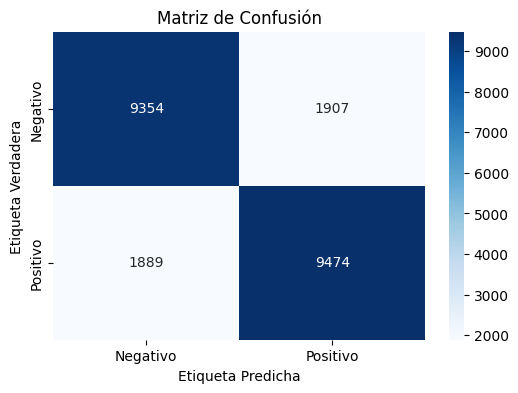

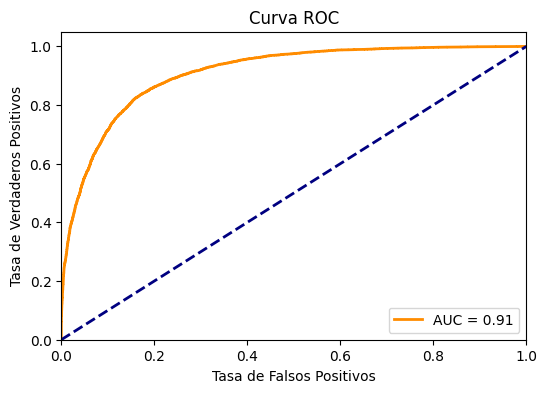

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     11261
           1       0.83      0.83      0.83     11363

    accuracy                           0.83     22624
   macro avg       0.83      0.83      0.83     22624
weighted avg       0.83      0.83      0.83     22624



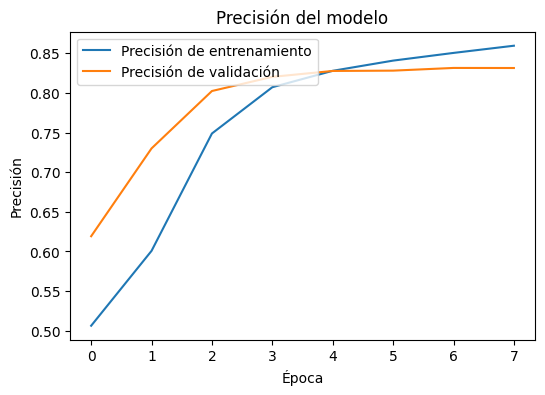

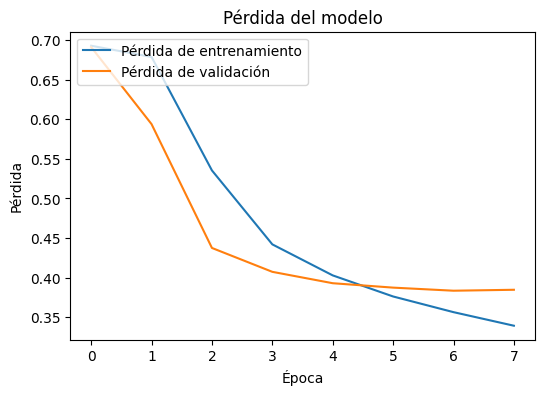

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import numpy as np

# Predicciones en el conjunto de test
y_pred_prob = model.predict(x_test_seq)  # Predicción de probabilidades
y_pred_class = (y_pred_prob > 0.5).astype("int32")  # Convertir probabilidades a 0 o 1

# 1. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

# 2. Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# 3. Informe de clasificación (precision, recall, F1-score)
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred_class))

# 4. Gráficos de la precisión y la pérdida
# Precisión
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()

# Pérdida
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()

## Ahora Importamos conjunto de datos de producción para testear el modelo

In [ ]:
ruta_test = "GOOGL_mensajes.csv"
df_new = pd.read_csv(ruta_test)
display(len(df_new))
display(df_new.head(10))
df_new['fecha_creacion'] = pd.to_datetime(df_new['fecha_creacion'])
df_new = df_new[df_new['fecha_creacion'].dt.year == 2024]
display(len(df_new))
df_new = df_new[["mensaje","sentimiento"]]
display(df_new.head(10))

290576

,simbolo,mensaje,fecha_creacion,nombre_usuario,fecha_creacion_usuario,oficial,identidad,titulo_link,descripcion_link,fecha_creacion_link,sentimiento
0,GOOGL,$GOOGL it favors upside as the part of 3 of (3...,2024-08-21T05:36:13Z,ElliottwaveForecast,2012-01-10,True,Official,NaN,NaN,NaN,NaN
1,ECPG,$ECPG $GOOGL 🏆💸,2024-08-21T04:17:45Z,Jduubbbb,2024-02-05,False,User,NaN,NaN,NaN,NaN
2,AMZN,$NVDA AI Usecases for Common man: \n\nCopilot ...,2024-08-21T04:12:05Z,OG9,2022-12-09,False,User,NaN,NaN,NaN,Bullish
3,T,$ASTS $GOOGL $VOD $T \nASTS v Starlink and why...,2024-08-21T03:43:02Z,DooScooby7,2021-02-12,False,User,NaN,NaN,NaN,Bullish
4,GOOGL,@cubie @jargv @Alvi722 @EBE_Day @ribbey @Thrax...,2024-08-21T03:10:09Z,jenbunn,2016-06-07,False,User,NaN,NaN,NaN,NaN
5,AMZN,$NVDA after earnings moving all to $AMZN and $...,2024-08-21T02:54:14Z,iHitPredict,2024-03-04,False,User,NaN,NaN,NaN,NaN
6,GOOGL,$GOOGL Waymo’s everywhere in CA! Soon they wil...,2024-08-21T02:17:48Z,DRockTrading,2017-12-20,False,User,NaN,NaN,NaN,Bullish
7,GOOG,$GOOGL Runner $GOOG $DIA,2024-08-21T02:02:44Z,uyenng25_,2023-10-25,False,User,NaN,NaN,NaN,NaN
8,GOOG,$UBER $LYFT $GOOG $GOOGL,2024-08-21T00:47:10Z,Avocado_smash,2021-07-10,False,User,NaN,NaN,NaN,NaN
9,GOOGL,$GOOGL,2024-08-20T23:31:28Z,Rufio8711,2016-04-15,False,User,NaN,NaN,NaN,NaN


22732

,mensaje,sentimiento
0,$GOOGL it favors upside as the part of 3 of (3...,NaN
1,$ECPG $GOOGL 🏆💸,NaN
2,$NVDA AI Usecases for Common man: \n\nCopilot ...,Bullish
3,$ASTS $GOOGL $VOD $T \nASTS v Starlink and why...,Bullish
4,@cubie @jargv @Alvi722 @EBE_Day @ribbey @Thrax...,NaN
5,$NVDA after earnings moving all to $AMZN and $...,NaN
6,$GOOGL Waymo’s everywhere in CA! Soon they wil...,Bullish
7,$GOOGL Runner $GOOG $DIA,NaN
8,$UBER $LYFT $GOOG $GOOGL,NaN
9,$GOOGL,NaN


In [ ]:
df_new = df_new.dropna(subset=['sentimiento'])
print(df_new['sentimiento'].value_counts())
display(len(df_new))
df_new['sentimiento'] = df_new['sentimiento'].apply(lambda x: 1 if x == 'Bullish' else 0)
# Eliminar registros con valores NaN en la columna 'msg'
df_new = df_new.dropna(subset=['mensaje'])
df_new['mensaje'] = df_new['mensaje'].astype(str)
# Preprocesamiento de los nuevos tweets
df_new['Preprocessed_text'] = df_new['mensaje'].apply(preprocess_tweet)
df_new = df_new[df_new['Preprocessed_text'].str.strip().astype(bool)]
df_new = df_new.dropna(subset=['Preprocessed_text'])

display(df_new.head(10))

Bullish    7730
Bearish    2004
Name: sentimiento, dtype: int64


9734

,mensaje,sentimiento,Preprocessed_text
2,$NVDA AI Usecases for Common man: \n\nCopilot ...,1,ai usecases for common man copilot from i use...
3,$ASTS $GOOGL $VOD $T \nASTS v Starlink and why...,1,asts v starlink and why starlink have gone ru...
6,$GOOGL Waymo’s everywhere in CA! Soon they wil...,1,waymos everywhere in ca soon they will take o...
11,$GOOGL $222.66 % locked in 💰💰💰\nSPY $328% lock...,1,locked in ddegddegddeg spy locked in
12,$GOOGL Waymo says it has doubled its weekly pa...,1,waymo says it has doubled its weekly paid rob...
14,$bidu $GOOGL chinese. google is selling off b...,1,chinese google is selling off before er it is...
15,Alphabet Inc. $GOOGL is trending on Reddit htt...,1,alphabet inc is trending on reddit
16,$GOOGL $GOOG yesterday&#39;s entry.,1,yesterday39s entry
30,"$PDD same same . Also, $GOOGL has been condens...",1,same same also has been condensed recently an...
32,$GOOGL 180 calls by sep 20,1,180 calls by sep 20


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


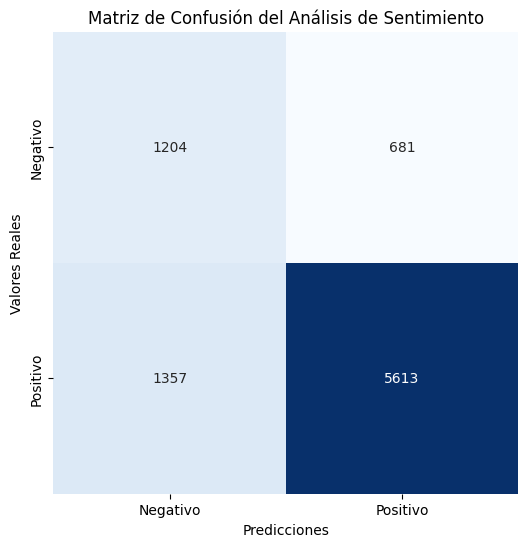

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      2561
           1       0.81      0.89      0.85      6294

    accuracy                           0.77      8855
   macro avg       0.72      0.68      0.69      8855
weighted avg       0.76      0.77      0.76      8855

Exactitud (Accuracy): 0.7698
Precisión (Precision): 0.8918
Recall: 0.8053
F1-Score: 0.8464


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Tokenización y padding
x_new_seq = tokenizer.texts_to_sequences(df_new['Preprocessed_text'])
x_new_seq = pad_sequences(x_new_seq, maxlen=20, padding='post')

# Predicción de sentimientos en los nuevos datos
predictions = model.predict(x_new_seq)

# Convertir probabilidades en etiquetas binarias (0 o 1)
predicted_labels = (predictions > 0.50).astype(int)

# Asumiendo que tenemos las etiquetas reales en el dataset nuevo para comparación
y_true = df_new['sentimiento']  # Ajustar según tu variable objetivo

# Generar la matriz de confusión
cm = confusion_matrix(y_true, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión del Análisis de Sentimiento')
plt.show()
# 3. Informe de clasificación (precision, recall, F1-score)
print('Informe de Clasificación:')
print(classification_report(predicted_labels, y_true))

accuracy = accuracy_score(y_true, predicted_labels)
precision = precision_score(y_true, predicted_labels)
recall = recall_score(y_true, predicted_labels)
f1 = f1_score(y_true, predicted_labels)

# Imprimir las métricas
print(f'Exactitud (Accuracy): {accuracy:.4f}')
print(f'Precisión (Precision): {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
from tensorflow.keras.models import load_model
# Guardar el modelo o continuar el entrenamiento
model.save("AnalisisSentimientoFinal.keras")
model = load_model('AnalisisSentimientoFinal.keras')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 100)             │       7,629,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 20, 100)             │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 100)             │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 20, 100)             │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,204,705 (88.52 MB)

 Trainable params: 7,734,901 (29.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,469,804 (59.01 MB)